# Regularized Logistic Regression

This is a worked solution in Julia to the second part of [Exercise 5](http://openclassroom.stanford.edu/MainFolder/DocumentPage.php?course=MachineLearning&doc=exercises/ex5/ex5.html) from Andrew Ng's [Machine Learning](http://openclassroom.stanford.edu/MainFolder/CoursePage.php?course=MachineLearning) course on Stanford's [OpenClassroom](http://openclassroom.stanford.edu/MainFolder/HomePage.php).
$
\newcommand{\cond}{{\mkern+2mu} \vert {\mkern+2mu}}
\newcommand{\SetDiff}{\mathrel{\backslash}}
\DeclareMathOperator{\BetaFunc}{Β}
\DeclareMathOperator{\GammaFunc}{Γ}
\DeclareMathOperator{\prob}{p}
\DeclareMathOperator{\cost}{J}
\DeclareMathOperator{\score}{V}
\DeclareMathOperator{\gradient}{\nabla}
\DeclareMathOperator{\Hessian}{H}
\DeclareMathOperator{\dcategorical}{Categorical}
\DeclareMathOperator{\dcategorical}{Categorical}
\DeclareMathOperator{\ddirichlet}{Dirichlet}
\DeclareMathOperator{\E}{e}
$

## Plotting

Set up the [Plots.jl](https://github.com/tbreloff/Plots.jl) package along with a simple scatter plot and probability contour overlay.

In [1]:
using Plots

gadfly()

function base_plot(U, V, Y)
    scatter(
        x = U, xlabel = "U", xlimits = (-1, 1.5),
        y = V, ylabel = "V", ylimits = (-1, 1.5),
        group = map((y) -> ["y = 0", "y = 1"][y+1], Y),
        markercolor = [colorant"Red" colorant"LightSkyBlue"],
        markersize = 4,
        size = (550, 500) )
end

function contour_plot(U, V, Y, θ, λ)
    plt = base_plot(U, V, Y)
    plot!(
        plt,
        linspace(-1, 1.5, 200),
        linspace(-1, 1.5, 200),
        (x, y) -> h(map_feature(x, y), θ),
        title = "λ = $λ" )
end;

## Data

The data for this exercise is downloaded and unpacked from [ex5Data.zip](http://openclassroom.stanford.edu/MainFolder/courses/MachineLearning/exercises/ex5materials/ex5Data.zip).

In [2]:
Y = convert(AbstractVector{Int}, vec(readdlm("ex5Logy.dat")))
N = length(Y)
UV = readdlm("ex5Logx.dat", ',', Float64);
U = UV[:,1]
V = UV[:,2];

## Plot the data

First thing to do is to look at the data.

[Plots.jl] Initializing backend: gadfly

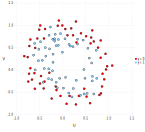

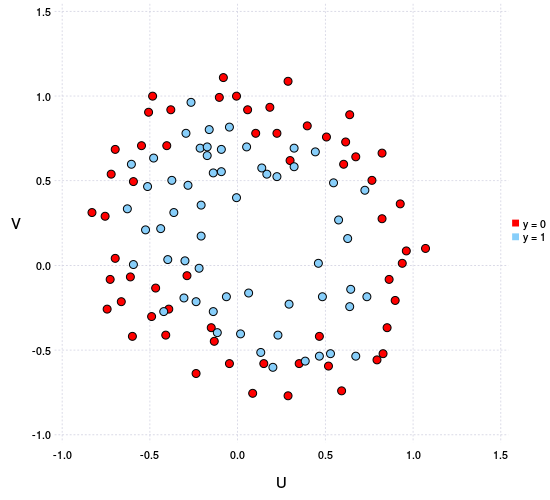

In [3]:
base_plot(U, V, Y)

The predictors in this exercise will be all monomials of $U$ and $V$ up to the sixth power.
$$
x = (1, u, v, u^2, uv, v^2, \dotsc, v^6)^{\text{T}}.
$$

In [4]:
function map_feature(feat1::Number, feat2::Number)
    return vec(map_feature([feat1], [feat2]))
end

function map_feature(feat1::AbstractVector, feat2::AbstractVector)
    degree = 6
    
    out = ones(size(feat1))
    
    for i = 1:degree
        for j = 0:i
            out = [out (feat1.^(i-j)) .* (feat2.^j)]
        end
    end
    
    return out
end;

In [5]:
X = map_feature(U, V);
P = size(X, 2)

28

The sigmoid function, $g(α) = \dfrac{1}{1 + \E^{-α}}$.

In [6]:
function sigmoid(α)
    1 ./ (1 .+ exp(-α))
end;

The hypothesis function, $h_θ(x) = g(θ^{\text{T}}x) = \prob(y = 1 \cond x; θ)$.

In [7]:
function h(xₙ::AbstractVector, θ::AbstractVector)
    sigmoid(dot(xₙ, θ))
end

function h(X::AbstractMatrix, θ::AbstractVector)
    sigmoid(X * θ)
end;

The regularised cost function, $\cost(θ)$, is defined as
$$
\cost(θ) = \frac{1}{N} \sum_{n=1}^N \big[ -y_n \log(h_θ(x_n)) - (1 - y_n) \log(1 - h_θ(x_n)) \big] + \frac{λ}{2N} θ^{\text{T}} θ.
$$

In [8]:
function cost(X::AbstractMatrix, Y::AbstractVector, θ::AbstractVector, λ::Number)
    N = length(Y)
    hₓ = h(X, θ)
    
    J = sum(-Y .* log(hₓ) - (1 .- Y) .* log(1 - hₓ)) / N
    
    reg = λ/(2N) * dot(θ, θ)
    
    return J + reg
end;

The gradient, $\gradient_θ\cost$, of the regularised cost function is

$$
\gradient_θ\cost = \begin{bmatrix}
\frac{1}{N} \sum_{n=1}^N (h_θ(x_n) - y_n) x_{n0} \\
\frac{1}{N} \sum_{n=1}^N (h_θ(x_n) - y_n) x_{n1} + \frac{λ}{N}\theta_1 \\
\frac{1}{N} \sum_{n=1}^N (h_θ(x_n) - y_n) x_{n2} + \frac{λ}{N}\theta_2 \\
\vdots \\
\frac{1}{N} \sum_{n=1}^N (h_θ(x_n) - y_n) x_{nN} + \frac{λ}{N}\theta_N \\
\end{bmatrix}.
$$

In [9]:
function gradient(X::AbstractMatrix, Y::AbstractVector, θ::AbstractVector, λ::Number)
    N = length(Y)
    hₓ = h(X, θ)
    
    ∇ = vec(sum((hₓ .- Y) .* X, 1)) ./ N
    
    reg = λ .* θ ./ N
    reg[1] = 0
    
    return ∇ .+ reg
end;

The Hessian, $\Hessian$, of the regularised cost function is

$$
\Hessian = \frac{1}{N} \sum_{n=1}^N \big[ h_θ(x_n) (1 - h_θ(x_n)) x_n x_n^{\text{T}} \big] + \frac{λ}{N} \begin{bmatrix}
0 & & & \\
& 1 & & \\
& & \ddots & \\
& & & 1
\end{bmatrix}.
$$

In [10]:
function Hessian(X::AbstractMatrix, Y::AbstractVector, θ::AbstractVector, λ::Number)
    N = length(Y)
    P = length(θ)
    hₓ = h(X, θ)
    
    σ² = hₓ .* (1 - hₓ)
    
    H = zeros(Float64, (P, P))
    
    for i in 1:N
        H .+= σ²[i] .* X[i, :]' * X[i, :]
    end
    
    H ./= N
    
    reg = λ/N .* eye(P)
    reg[1, 1] = 0
    
    return H .+ reg
end;

The update rule for Newton's method is $θ′ = θ - \Hessian^{-1} \gradient_θ \cost$.

In [11]:
function Newtons(X::AbstractMatrix, Y::AbstractVector, θ::AbstractVector, λ::Number)
    MAX_ITER = 1000
    TOLERANCE = 1e-9

    J = Array{Float64}(MAX_ITER)
    J[1] = cost(X, Y, θ, λ)

    for i in 2:MAX_ITER
        ∇J = gradient(X, Y, θ, λ)
        H = Hessian(X, Y, θ, λ)

        θ -= H \ ∇J

        J[i] = cost(X, Y, θ, λ)

        if norm(J[i] - J[i-1]) < TOLERANCE
            return (θ, J[1:i])
        end
    end

    error("Failed to converge after $MAX_ITER iterations")
end;

Now we can use Newton's method to solve the classification problem for any required value of the regularisation parameter, `λ`. We use all zeros as the initial values of the parameters, `θ`.

In [12]:
λ = 0.1

(θ, J) = Newtons(X, Y, zeros((P,)), λ)

println("Converged after $(length(J)) iterations")
println("norm(θ) = $(norm(θ))")

Converged after 7 iterations
norm(θ) = 10.88231256360369


A plot of the value of the cost function at each iteration demonstrates the speed of convergence.

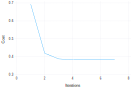

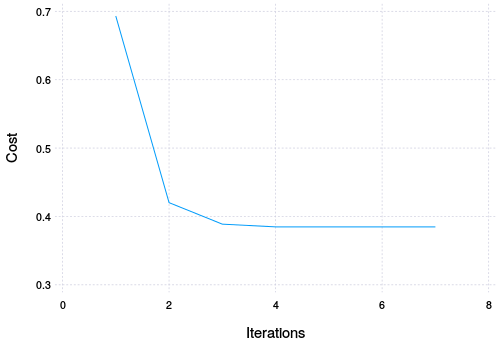

In [13]:
plot(
    J,
    xlabel = "Iterations", ylabel = "Cost", legend = false,
    size = (500, 350) )

## Decision boundary

Given a solution to the classification problem, we can plot the decision boundary over the data. The plot here shows not the decision boundary itself but the contours of $\prob(y = 1 \cond x; θ)$, the class probabilities. The decision boundary is at $\prob(y = 1 \cond x; θ) = 0.5$, which corresponds to $θ^{\text{T}}x = 0$.

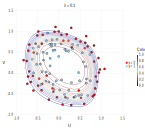

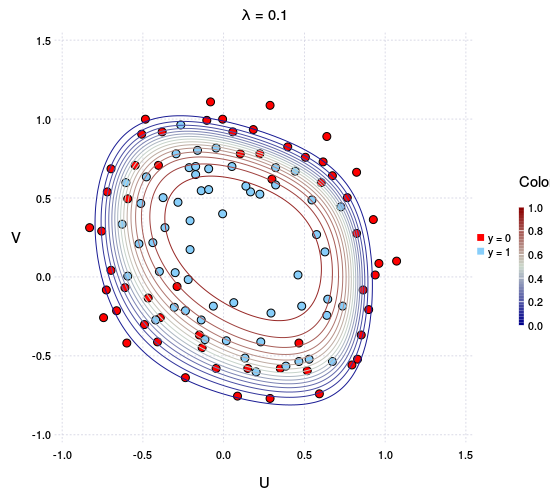

In [14]:
contour_plot(U, V, Y, θ, λ)